# Crossentropy method

This notebook will teach you to solve reinforcement learning problems with crossentropy method. We'll follow-up by scaling everything up and using neural network policy.

In [1]:
#XVFB will be launched if you run on a server
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [2]:
import gym
import numpy as np, pandas as pd

env = gym.make("Taxi-v2")
env.reset()
env.render()

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [4]:
n_states = env.observation_space.n
n_actions = env.action_space.n

print("n_states=%i, n_actions=%i"%(n_states,n_actions))

n_states=500, n_actions=6


# Create stochastic policy

This time our policy should be a probability distribution.

```policy[s,a] = P(take action a | in state s)```

Since we still use integer state and action representations, you can use a 2-dimensional array to represent the policy.

Please initialize policy __uniformly__, that is, probabililities of all actions should be equal.


In [5]:
policy = np.ones((n_states, n_actions)) / n_actions

In [6]:
assert type(policy) in (np.ndarray,np.matrix)
assert np.allclose(policy,1./n_actions)
assert np.allclose(np.sum(policy,axis=1), 1)

# Play the game

Just like before, but we also record all states and actions we took.

In [3]:
def generate_session(policy,t_max=10**4):
    """
    Play game until end or for t_max ticks.
    :param policy: an array of shape [n_states,n_actions] with action probabilities
    :returns: list of states, list of actions and sum of rewards
    """
    states, actions = [],[]
    total_reward = 0.
    
    s = env.reset()
    
    for t in range(t_max):
        
        a = np.random.choice(np.arange(n_actions), p=policy[s])
        
        new_s,r,done,info = env.step(a)
        
        #Record state, action and add up reward to states,actions and total_reward accordingly. 
        states.append(s)
        actions.append(a)
        total_reward+=r
        
        s = new_s
        if done:
            break
    return states,actions,total_reward
        

In [8]:
s,a,r = generate_session(policy)
assert type(s) == type(a) == list
assert len(s) == len(a)
assert type(r) in [float,np.float]

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

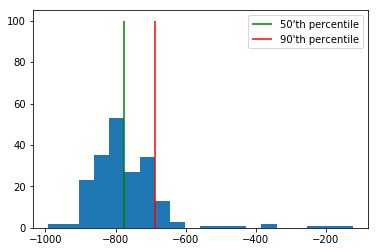

In [9]:
#let's see the initial reward distribution


sample_rewards = [generate_session(policy,t_max=1000)[-1] for _ in range(200)]

plt.hist(sample_rewards,bins=20);
plt.vlines([np.percentile(sample_rewards,50)],[0],[100],label="50'th percentile",color='green')
plt.vlines([np.percentile(sample_rewards,90)],[0],[100],label="90'th percentile",color='red')
plt.legend()

### Crossentropy method steps (2pts)

In [5]:
def select_elites(states_batch,actions_batch,rewards_batch,percentile=50):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i][t]
    
    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions
    
    Please return elite states and actions in their original order 
    [i.e. sorted by session number and timestep within session]
    
    If you're confused, see examples below. Please don't assume that states are integers (they'll get different later).
    """
    
    reward_threshold = np.percentile(rewards_batch, percentile)
    
    elite_states  = np.concatenate(tuple(states for i, states in enumerate(states_batch)
                                    if rewards_batch[i] >= reward_threshold))
    elite_actions = np.concatenate(tuple(action for i, action in enumerate(actions_batch)
                                    if rewards_batch[i] >= reward_threshold))
    
    return elite_states,elite_actions
    

In [11]:
states_batch = [
    [1,2,3],   #game1
    [4,2,0,2], #game2
    [3,1]      #game3
]

actions_batch = [
    [0,2,4],   #game1
    [3,2,0,1], #game2
    [3,3]      #game3
]
rewards_batch = [
    3,         #game1
    4,         #game2
    5,         #game3
]

test_result_0 = select_elites(states_batch,actions_batch,rewards_batch,percentile=0)
test_result_40 = select_elites(states_batch,actions_batch,rewards_batch,percentile=30)
test_result_90 = select_elites(states_batch,actions_batch,rewards_batch,percentile=90)
test_result_100 = select_elites(states_batch,actions_batch,rewards_batch,percentile=100)

assert np.all(test_result_0[0] == [1, 2, 3, 4, 2, 0, 2, 3, 1])  \
   and np.all(test_result_0[1] == [0, 2, 4, 3, 2, 0, 1, 3, 3]),\
        "For percentile 0 you should return all states and actions in chronological order"
assert np.all(test_result_40[0] == [4, 2, 0, 2, 3, 1]) and \
        np.all(test_result_40[1] ==[3, 2, 0, 1, 3, 3]),\
        "For percentile 30 you should only select states/actions from two first"
assert np.all(test_result_90[0] == [3,1]) and \
        np.all(test_result_90[1] == [3,3]),\
        "For percentile 90 you should only select states/actions from one game"
assert np.all(test_result_100[0] == [3,1]) and\
       np.all(test_result_100[1] == [3,3]),\
        "Please make sure you use >=, not >. Also double-check how you compute percentile."
print("Ok!")

Ok!


In [6]:
from collections import Counter, defaultdict

In [7]:
def update_policy(elite_states,elite_actions):
    """
    Given old policy and a list of elite states/actions from select_elites,
    return new updated policy where each action probability is proportional to
    
    policy[s_i,a_i] ~ #[occurences of si and ai in elite states/actions]
    
    Don't forget to normalize policy to get valid probabilities and handle 0/0 case.
    In case you never visited a state, set probabilities for all actions to 1./n_actions
    
    :param elite_states: 1D list of states from elite sessions
    :param elite_actions: 1D list of actions from elite sessions
    
    """
        
    states_dict = defaultdict(int)
    actions_dict = defaultdict(lambda: defaultdict(int))
    
    for state, action in zip(elite_states, elite_actions):
        states_dict[state] += 1
        actions_dict[state][action] += 1
        
    new_policy = np.ones((n_states, n_actions)) / n_actions
    
    for state in states_dict.keys():
        for action in np.arange(n_actions):
            new_policy[state][action] = actions_dict[state][action] / states_dict[state]
    #Don't forget to set 1/n_actions for all actions in unvisited states.
    
    
    return new_policy

In [14]:

elite_states, elite_actions = ([1, 2, 3, 4, 2, 0, 2, 3, 1], [0, 2, 4, 3, 2, 0, 1, 3, 3])


new_policy = update_policy(elite_states,elite_actions)

assert np.isfinite(new_policy).all(), "Your new policy contains NaNs or +-inf. Make sure you don't divide by zero."
assert np.all(new_policy>=0), "Your new policy can't have negative action probabilities"
assert np.allclose(new_policy.sum(axis=-1),1), "Your new policy should be a valid probability distribution over actions"
reference_answer = np.array([
       [ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.5       ,  0.        ,  0.        ,  0.5       ,  0.        ],
       [ 0.        ,  0.33333333,  0.66666667,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.5       ,  0.5       ]])
assert np.allclose(new_policy[:4,:5],reference_answer)
print("Ok!")

Ok!


# Training loop
Generate sessions, select N best and fit to those.

In [8]:
from IPython.display import clear_output

def show_progress(rewards_batch, log, percentile=70):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """
    
    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch,percentile)
    log.append([mean_reward,threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f"%(mean_reward,threshold))
    plt.figure(figsize=[13,4])
    plt.subplot(1,3,1)
    plt.plot(list(zip(*log))[0],label='Mean rewards')
    plt.plot(list(zip(*log))[1],label='Reward thresholds')
    plt.legend()
    plt.grid()
    
    plt.subplot(1,3,2)
    plt.plot(list(zip(*(log[-10:])))[0],label='Mean rewards')
    plt.plot(list(zip(*(log[-10:])))[1],label='Reward thresholds')
    plt.legend()
    plt.grid()
    
    plt.subplot(1,3,3)
    plt.hist(rewards_batch);
    plt.vlines([np.percentile(rewards_batch,percentile)],[0],[100],label="percentile",color='red')
    plt.legend()
    plt.grid()

    plt.show()


In [16]:
#reset policy just in case
policy = np.ones([n_states, n_actions]) / n_actions 

mean reward = -85.436, threshold=6.500


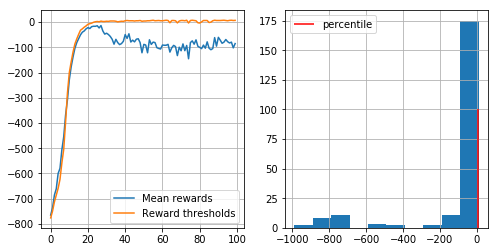

In [17]:
n_sessions = 250  #sample this many sessions
percentile = 50  #take this percent of session with highest rewards
learning_rate = 0.5  #add this thing to all counts for stability

log = []

for i in range(100):
    
    %time sessions = [generate_session(policy) for _ in range(n_sessions)]
    
    states_batch,actions_batch,rewards_batch = zip(*sessions)

    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)
    
    new_policy = update_policy(elite_states, elite_actions)
    
    policy = learning_rate*new_policy + (1-learning_rate)*policy
    
    #display results on chart
    show_progress(rewards_batch,log)

# Digging deeper: approximate crossentropy with neural nets

![img](https://casd35.wikispaces.com/file/view/digging_deeper_final.jpg/359658499/503x260/digging_deeper_final.jpg)

In this section we will train a neural network policy for continuous state space game

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


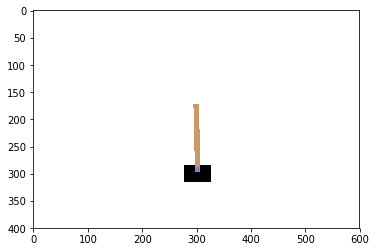

In [50]:
env = gym.make("CartPole-v0").env  #if you see "<classname> has no attribute .env", remove .env or update gym

env.reset()
n_actions = env.action_space.n

plt.imshow(env.render("rgb_array"))

In [9]:
from sklearn.neural_network import MLPClassifier, MLPRegressor

In [11]:
#create agent
agent = MLPClassifier(hidden_layer_sizes=(20,20),
                      activation='tanh',
                      warm_start=True, #keep progress between .fit(...) calls
                      max_iter=1 #make only 1 iteration on each .fit(...)
                     )
#initialize agent to the dimension of state an amount of actions
agent.fit([env.reset()]*n_actions,range(n_actions));


ValueError: Expected 2D array, got 1D array instead:
array=[124 124 124 124 124 124].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [10]:
def generate_session(t_max=1000):
    
    states,actions = [],[]
    total_reward = 0
    
    s = env.reset()
    
    for t in range(t_max):
        
        #predict array of action probabilities
        probs = agent.predict_proba([s])[0] 
        
        a = np.random.choice(np.arange(n_actions), p=probs)
        
        new_s,r,done,info = env.step(a)
        
        #record sessions like you did before
        states.append(s)
        actions.append(a)
        total_reward+=r
        
        s = new_s
        if done: break
    return states,actions,total_reward
        

mean reward = 979.910, threshold=1000.000


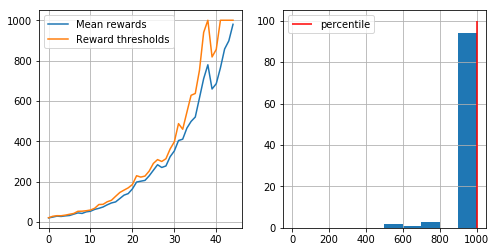

You Win! You may stop training now via KeyboardInterrupt.


KeyboardInterrupt: 

In [53]:
n_sessions = 100
percentile = 70
log = []

for i in range(100):
    #generate new sessions
    sessions = [generate_session() for i in range(n_sessions)]

    states_batch,actions_batch,rewards_batch = map(np.array,zip(*sessions))

    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch)
    
    agent.fit(elite_states, elite_actions)

    show_progress(rewards_batch,log,reward_range=[0,np.max(rewards_batch)])
    
    if np.mean(rewards_batch)> 190:
        print("You Win! You may stop training now via KeyboardInterrupt.")

# Results

In [54]:
#record sessions
import gym.wrappers
env = gym.wrappers.Monitor(gym.make("CartPole-v0"),directory="videos",force=True)
sessions = [generate_session() for _ in range(100)]
env.close()
#upload to gym
#gym.upload("./videos/",api_key="<your_api_key>") #you'll need me later

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [55]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1])) #this may or may not be _last_ video. Try other indices

# Homework part I

### Tabular crossentropy method

You may have noticed that the taxi problem quickly converges from -100 to a near-optimal score and then descends back into -50/-100. This is in part because the environment has some innate randomness. Namely, the starting points of passenger/driver change from episode to episode.

### Tasks
- __1.1__ (1 pts) Find out how the algorithm performance changes if you change different percentile and different n_samples.
- __1.2__ (2 pts) Tune the algorithm to end up with positive average score.

It's okay to modify the existing code.


In [22]:
policy

array([[1.66666667e-01, 1.66666667e-01, 1.66666667e-01, 1.66666667e-01,
        1.66666667e-01, 1.66666667e-01],
       [6.31098431e-27, 8.36478516e-26, 9.87403772e-26, 3.52000746e-25,
        1.00000000e+00, 1.14585119e-27],
       [1.20703178e-27, 3.85016137e-21, 6.57714393e-25, 2.07410835e-10,
        1.00000000e+00, 1.12709170e-27],
       ...,
       [1.66666667e-01, 1.66666667e-01, 1.66666667e-01, 1.66666667e-01,
        1.66666667e-01, 1.66666667e-01],
       [1.66666667e-01, 1.66666667e-01, 1.66666667e-01, 1.66666667e-01,
        1.66666667e-01, 1.66666667e-01],
       [1.66666667e-01, 1.66666667e-01, 1.66666667e-01, 1.66666667e-01,
        1.66666667e-01, 1.66666667e-01]])

In [41]:
def train_taxi(percentile, n_sessions, n_iter=100, learning_rate=0.5):
    log = []
    _policy = np.ones([n_states, n_actions]) / n_actions 
    
    for i in range(n_iter):

        sessions = [generate_session(_policy) for _ in range(n_sessions)]

        states_batch, actions_batch, rewards_batch = zip(*sessions)

        elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)

        new__policy = update_policy(elite_states, elite_actions)

        _policy = learning_rate*new__policy + (1-learning_rate)*_policy

        #display results on chart
        show_progress(rewards_batch, log)
    return np.mean([mean_reward for mean_reward, _ in log[-10:]])

Выводимое функцией число - средний reward за последние 10 итераций

mean reward = -393.516, threshold=-283.500


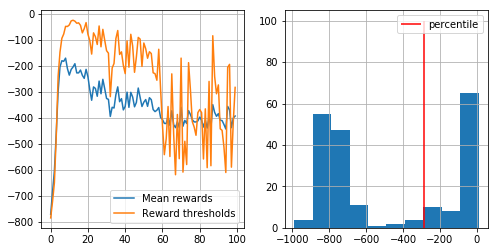

-403.33520000000004

In [42]:
train_taxi(80, 250)

mean reward = -145.728, threshold=-3.500


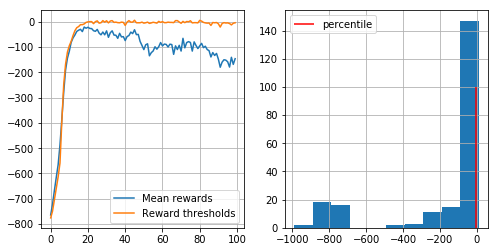

-157.8788

In [43]:
train_taxi(60, 250)

mean reward = -10.456, threshold=6.000


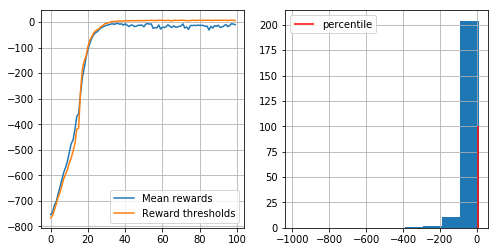

-13.600400000000002

In [44]:
train_taxi(40, 250)

mean reward = -0.024, threshold=6.000


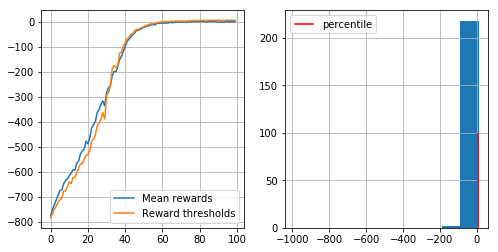

-0.472

In [49]:
train_taxi(20, 250)

mean reward = -62.900, threshold=-35.500


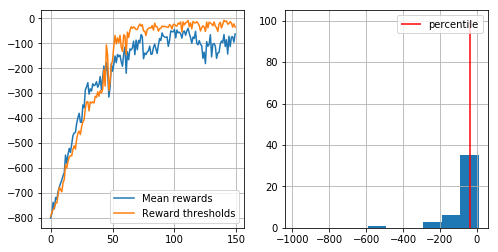

-90.148

In [46]:
train_taxi(20, 50, n_iter=150)

mean reward = -16.847, threshold=4.000


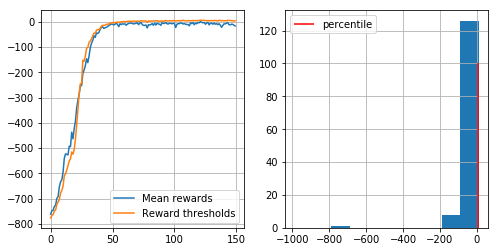

-9.849999999999998

In [47]:
train_taxi(20, 150, n_iter=150)

mean reward = 2.137, threshold=7.000


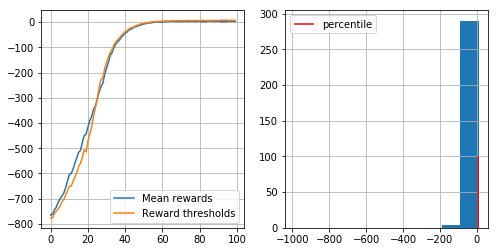

2.2802857142857142

In [48]:
train_taxi(20, 350)

Запустил обучение с персентилями 80, 60, 40, 20 при фиксированном числе сессий - 250, после чего запустил обучение с 50, 150, и 350 сессиями при фиксированной персентили - 20.  

При уменьшении персентили скорость сходимости снижается, но зато в конце не происходит падения результатов. Вероятно, это происходит из-за того, что с такой низкой персентилью в элитные сценарии начинают попадать ситуации, когда случайные стартовые позиции неудачные, и, благодоря этому, модель учится действовать правильно в таких случаях. Небольшое число игр увеличивает стабильность попадания в элитность этих случаев. При небольшом числе игр, в элитные сценарии могут часто попадать плохие сценарии, поэтому рост результата происходит гораздо менее стабильно и, как следствие, медленней.

При персентили 20 и числе игр 350 скор доходит до положительного и не падает.

# Homework part II

### Deep crossentropy method

By this moment you should have got enough score on [CartPole-v0](https://gym.openai.com/envs/CartPole-v0) to consider it solved (see the link). It's time to upload the result and get to something harder.

* if you have any trouble with CartPole-v0 and feel stuck, feel free to ask us or your peers for help.

### Tasks

* __2.1__ (3 pts) Pick one of environments: MountainCar-v0 or LunarLander-v2.
  * For MountainCar, get average reward of __at least -150__
  * For LunarLander, get average reward of __at least +50__
  * For any environment, upload it to gym and post url in your anytask form.

See the tips section below, it's kinda important.
__Note:__ If your agent is below the target score, you'll still get most of the points depending on the result, so don't be afraid to submit it.
  
  
* __2.2__ (bonus: 4++ pt) Devise a way to speed up training at least 2x against the default version
  * Obvious improvement: use [joblib](https://www.google.com/search?client=ubuntu&channel=fs&q=joblib&ie=utf-8&oe=utf-8)
  * Try re-using samples from 3-5 last iterations when computing threshold and training
  * Experiment with amount of training iterations and learning rate of the neural network (see params)
  * __Please list what you did in anytask submission form__
  
  
### Tips
* Gym page: [mountaincar](https://gym.openai.com/envs/MountainCar-v0), [lunarlander](https://gym.openai.com/envs/LunarLander-v2)
* Sessions for MountainCar may last for 10k+ ticks. Make sure ```t_max``` param is at least 10k.
 * Also it may be a good idea to cut rewards via ">" and not ">=". If 90% of your sessions get reward of -10k and 20% are better, than if you use percentile 20% as threshold, R >= threshold __fails cut off bad sessions__ whule R > threshold works alright.
* _issue with gym_: Some versions of gym limit game time by 200 ticks. This will prevent cem training in most cases. Make sure your agent is able to play for the specified __t_max__, and if it isn't, try `env = gym.make("MountainCar-v0").env` or otherwise get rid of TimeLimit wrapper.
* If you use old _swig_ lib for LunarLander-v2, you may get an error. See this [issue](https://github.com/openai/gym/issues/100) for solution.
* If it won't train it's a good idea to plot reward distribution and record sessions: they may give you some clue. If they don't, call course staff :)
* 20-neuron network is probably not enough, feel free to experiment.
* __Please upload the results to openai gym and send links to all submissions in the e-mail__

### Bonus tasks

* __2.3 bonus__ Try to find a network architecture and training params that solve __both__ environments above (_Points depend on implementation. If you attempted this task, please mention it in anytask submission._)

* __2.4 bonus__ Solve continuous action space task with `MLPRegressor` or similar.
  * [MountainCarContinuous-v0](https://gym.openai.com/envs/MountainCarContinuous-v0), [LunarLanderContinuous-v2](https://gym.openai.com/envs/LunarLanderContinuous-v2) 
  * 4 points for solving. Slightly less for getting some results below solution threshold. Note that discrete and continuous environments may have slightly different rules aside from action spaces.


If you're still feeling unchallenged, consider the project (see other notebook in this folder).

# 2.1

In [11]:
env = gym.make("MountainCar-v0").env
n_actions = env.action_space.n

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [11]:
def generate_session(t_max=20000):
    
    states,actions = [],[]
    total_reward = 0
    
    s = env.reset()
    
    for t in range(t_max):
        
        #predict array of action probabilities
        probs = agent.predict_proba([s])[0] 
        
        a = np.random.choice(np.arange(n_actions), p=probs)
        
        new_s,r,done,info = env.step(a)
        
        #record sessions like you did before
        states.append(s)
        actions.append(a)
        total_reward+=r
        
        s = new_s
        if done: break
    return states,actions,total_reward

Возьмем 400 сессий

mean reward = -125.888, threshold=-111.000


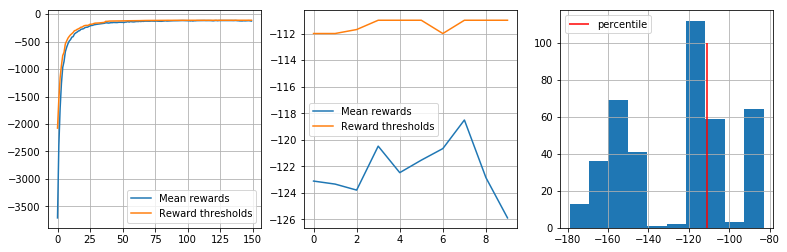

You Win! You may stop training now via KeyboardInterrupt.
CPU times: user 25min 31s, sys: 1min 15s, total: 26min 46s
Wall time: 25min 11s


In [26]:
%%time

agent = MLPClassifier(hidden_layer_sizes=(20,20),
                      activation='tanh',
                      warm_start=True,
                      max_iter=1
                     )
#initialize agent to the dimension of state an amount of actions
agent.fit([env.reset()]*n_actions, range(n_actions))
n_sessions = 400
percentile = 70
log = []

for _ in range(150):
    #generate new sessions
    sessions = [generate_session() for i in range(n_sessions)]

    states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))

    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)
    
    agent.fit(elite_states, elite_actions)

    show_progress(rewards_batch, log)
    
    if np.mean(rewards_batch) > -150:
        print("You Win! You may stop training now via KeyboardInterrupt.")

-150 достигнуто :)

# 2.2

In [12]:
nn_params = {
    'hidden_layer_sizes': (20,20),
    'activation': 'tanh',
    'warm_start': True,
    'max_iter': 1,
}

In [18]:
agent = MLPClassifier(**nn_params)
agent.fit([env.reset()]*n_actions, range(n_actions))

/home/onaga/Docs/Practical_RL/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(20, 20), learning_rate='constant',
       learning_rate_init=0.01, max_iter=1, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=True)

Будем заканчивать обучение, если три хода подряд средняя награда выше порога

In [13]:
def train_env(n_sessions=400, percentile=70, n_iter=150, parallel=True):
    log = []

    win_iters = 0
    for _ in range(n_iter):
        #generate new sessions
        if parallel:
            sessions = Parallel(n_jobs=2)(delayed(generate_session)() for i in range(n_sessions))
        else:
            sessions = [generate_session() for i in range(n_sessions)]

        states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))

        elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)

        agent.fit(elite_states, elite_actions)

        show_progress(rewards_batch, log)

        if np.mean(rewards_batch) > -150:
            win_iters += 1
            if win_iters == 3:
                print('Win!')
                break
        else:
            win_iters = 0

Измерим время дефолтного алгоритма

In [35]:
agent = MLPClassifier(**nn_params)
agent.fit([env.reset()]*n_actions, range(n_actions))

/home/onaga/Docs/Practical_RL/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(20, 20), learning_rate='constant',
       learning_rate_init=0.001, max_iter=1, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=True)

mean reward = -144.795, threshold=-115.000


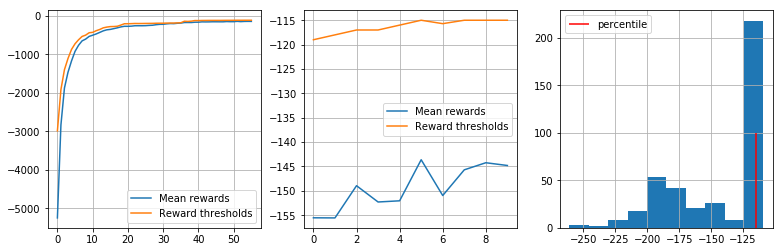

Win!
CPU times: user 20min 52s, sys: 38 s, total: 21min 30s
Wall time: 20min 40s


In [36]:
%%time
train_env(parallel=False)

Сошлось примерно за 55 итераций

Параллельный вариант этой же архитектуры

In [14]:
from joblib import Parallel, delayed

In [ ]:
agent = MLPClassifier(**nn_params)
agent.fit([env.reset()]*n_actions, range(n_actions))

mean reward = -148.095, threshold=-119.000


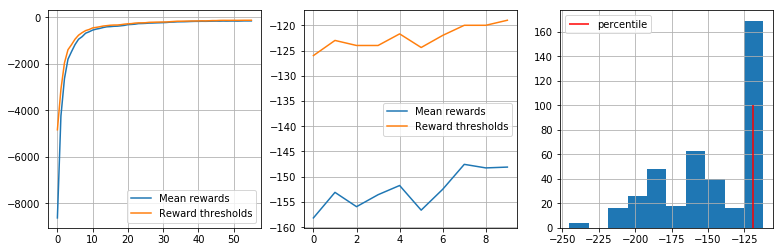

Win!
CPU times: user 1min 40s, sys: 53.9 s, total: 2min 34s
Wall time: 14min 37s


In [41]:
%%time

train_env()

Попробуем теперь использовать сессии с прошлых итераций

In [14]:
def update_batch(array, sessions, index, save_n_iters):
    if len(array) == save_n_iters * len(sessions):
        array = array[n_sessions:]
    return list(array) + [session[index] for session in sessions]

mean reward = -141.113, threshold=-140.000


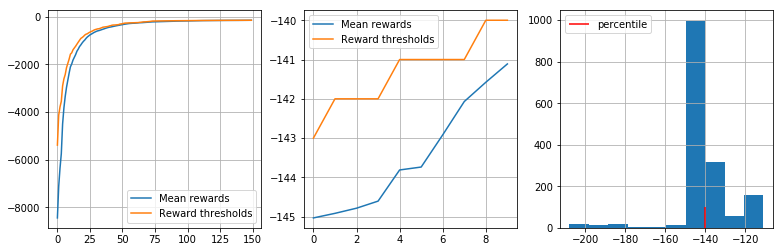

You Win! You may stop training now via KeyboardInterrupt.


In [22]:
agent = MLPClassifier(hidden_layer_sizes=(20,20),
                      activation='tanh',
                      warm_start=True,
                      max_iter=1
                     )
#initialize agent to the dimension of state an amount of actions
agent.fit([env.reset()]*n_actions, range(n_actions))

n_sessions = 400
percentile = 70
save_n_iters = 4
log = []
states_batch, actions_batch, rewards_batch = [np.array([])] * 3

for iteration in range(150):
    #generate new sessions
    sessions = Parallel(n_jobs=3)(delayed(generate_session)() for i in range(n_sessions))
    
    states_batch = update_batch(states_batch, sessions, 0, save_n_iters)
    actions_batch = update_batch(actions_batch, sessions, 1, save_n_iters)
    rewards_batch = update_batch(rewards_batch, sessions, 2, save_n_iters)

    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)
    
    agent.fit(elite_states, elite_actions)

    show_progress(rewards_batch, log)
    
    if np.mean(rewards_batch) > -150:
        print("You Win! You may stop training now via KeyboardInterrupt.")

Это скорее помешало, чем помогло

Попробуем поиграться с learning_rate'ом. Для начала просто увеличим его.

In [42]:
nn_params['learning_rate_init'] = 0.003

In [ ]:
agent = MLPClassifier(**nn_params)
agent.fit([env.reset()]*n_actions, range(n_actions))

mean reward = -136.625, threshold=-117.000


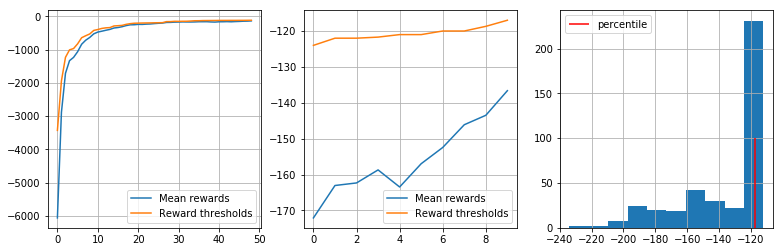

Win!
CPU times: user 1min 26s, sys: 49.9 s, total: 2min 16s
Wall time: 11min 25s


In [44]:
%%time

train_env()

Неплохо, еще увеличим

In [41]:
nn_params['learning_rate_init'] = 0.01
agent = MLPClassifier(**nn_params)
agent.fit([env.reset()]*n_actions, range(n_actions))

/home/onaga/Docs/Practical_RL/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(20, 20), learning_rate='constant',
       learning_rate_init=0.01, max_iter=1, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=True)

mean reward = -140.360, threshold=-119.000


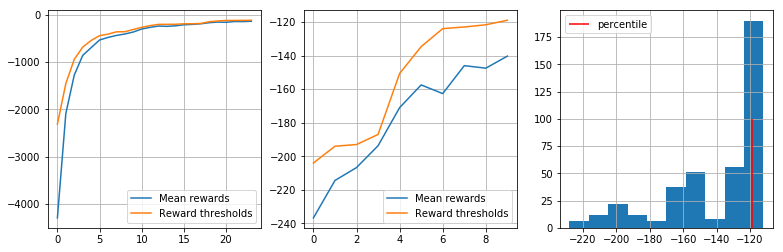

Win!
CPU times: user 45.3 s, sys: 26.2 s, total: 1min 11s
Wall time: 6min 8s


In [42]:
%%time

train_env()

Ура! Получилось добиться нужного ускорения. Дефолтный вариант работал 20 минут.

In [27]:
agent = MLPClassifier(**nn_params)
agent.fit([env.reset()]*n_actions, range(n_actions))

/home/onaga/Docs/Practical_RL/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(20, 20), learning_rate='constant',
       learning_rate_init=0.01, max_iter=1, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=True)

Попробуем увеличить число сессий

mean reward = -146.156, threshold=-121.000


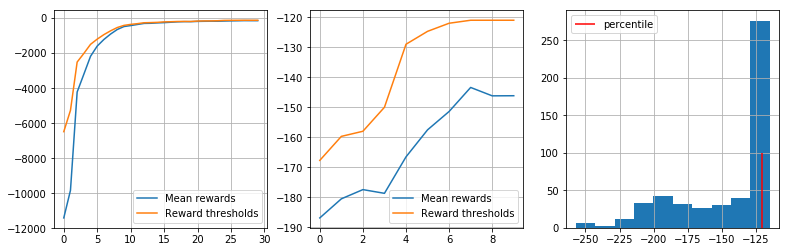

Win!
CPU times: user 1min 44s, sys: 30.1 s, total: 2min 14s
Wall time: 21min 12s


In [28]:
%%time

train_env(n_sessions=500)

Так себе, ну и ладно, нужный результат уже достигнут

# 2.3

In [15]:
def generate_session(agent, env, n_actions, t_max=20000):
    
    states,actions = [],[]
    total_reward = 0
    
    s = env.reset()
    
    for t in range(t_max):
        
        #predict array of action probabilities
        probs = agent.predict_proba([s])[0] 
        
        a = np.random.choice(np.arange(n_actions), p=probs)
        
        new_s,r,done,info = env.step(a)
        
        #record sessions like you did before
        states.append(s)
        actions.append(a)
        total_reward+=r
        
        s = new_s
        if done: break
    return states, actions, total_reward

In [23]:
def train_env(env, success_reward, model, first_sessions=None, fail_reward=-10000,
              n_sessions=400, percentile=70, n_iter=150, *args, **kwargs):
    restart = True
    while restart:
        restart = False
        agent = model(*args, **kwargs)
        n_actions = env.action_space.n
        agent.fit([env.reset()]*n_actions, range(n_actions))

        log = []
        win_iters = 0
        for ind in range(n_iter):
            #generate new sessions
            if ind == 0 and first_sessions is not None:
                sessions = first_sessions
            else:
                sessions = [generate_session(agent, env, n_actions) for i in range(n_sessions)]

            states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))

            elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)

            agent.fit(elite_states, elite_actions)

            show_progress(rewards_batch, log)

            if np.mean(rewards_batch) > success_reward:
                win_iters += 1
                if win_iters == 3:
                    print('Win!')
                    
                    break
            else:
                win_iters = 0

            if np.mean(rewards_batch) < fail_reward:
                restart = True
                break

In [24]:
car_reward = -150
car_env = gym.make("MountainCar-v0").env

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


Давайте запомним удачный пак стратегий, сгенерированный для необученного агента, то есть пак, который нужно получить на первой итерации алгоритма

In [35]:
agent = MLPClassifier(**nn_params)
n_actions = car_env.action_space.n
agent.fit([car_env.reset()]*n_actions, range(n_actions))
car_first_sessions = [generate_session(agent, car_env, n_actions) for i in range(400)]

/home/onaga/Docs/Practical_RL/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [36]:
states_batch, actions_batch, rewards_batch = map(np.array, zip(*car_first_sessions))
np.mean(rewards_batch)

-17659.5725

Хоть что-то, хочу уже запустить lander

In [37]:
lander_env = gym.make("LunarLander-v2").env
lander_reward = 50

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


Попробуем увевиличть размер скрытых слоев, потом можно еще попробовать увеличить percentile.

In [38]:
params = {
    'hidden_layer_sizes': (50,50),
    'activation': 'tanh',
    'warm_start': True,
    'max_iter': 1,
    'learning_rate_init': 0.01,
    'n_sessions': 400,
    'percentile': 70,
}

SyntaxError: invalid syntax (<ipython-input-38-06e21edeb576>, line 7)

mean reward = -56.570, threshold=-24.515


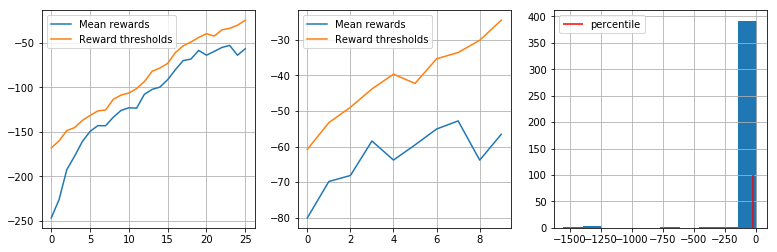

KeyboardInterrupt: 

In [39]:
train_env(lander_env, lander_reward, MLPClassifier, **params)

Это училось слишком долго, времени не хватило((

In [ ]:
train_env(car_env, car_reward, MLPClassifier, car_first_sessions, **params)

# 2.4

На это тоже не хватило времени(

In [ ]:
countinuous_car_env = gym.make('MountainCarContinuous-v0').env
countinuous_lander_env = gym.make('LunarLanderContinuous-v2').env

In [ ]:
train_env(countinuous_lander_env, lander_reward, MLPRegressor, **nn_params)

In [ ]:
train_env(countinuous_car_env, car_reward, MLPRegressor, **nn_params)